In [3]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import entropy
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

sns.set(color_codes=True, style="white", context="talk", font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:5] + PALETTE[6:], n_colors=9)


def truncate(n, dicimals=2):
    return round(n, dicimals)


# helper function to compare two numbers
def compare(A, B):
    if A > B:
        return ">"
    elif A < B:
        return "<"
    else:
        return "="

In [150]:
# For generating Variable C
def generate_gauss_mix(
    N=5000,
    prior=(0.5, 0.5),
    p=1,
    mu_class0=0,
    mu_class1=1,
    mu_class1_0=0,
    mu_class1_1=5,
    sig_class0=1,
    sig_class1=1,
    sig_class1_0=1,
    sig_class1_1=1,
    split_class1=None,
):
    class1_mix = True if split_class1 is not None else False
    prior_0, prior_1 = prior
    if class1_mix:
        p_class0, p_class1_0, p_class1_1 = (
            prior_0,
            prior_1 * split_class1[0],
            prior_1 * split_class1[1],
        )
        n0 = int(N * p_class0)  # number of samples from class 0
        n1 = N - n0  # total number of samples from class 1
        n1_0 = int(N * p_class1_0)  # number of samples from class 1_0
        n1_1 = n1 - n1_0  # number of samples from class 1_1

        mu_class0 = np.array([mu_class0] * p)

        mu_class1_0 = np.array([mu_class1_0] * p)
        mu_class1_1 = np.array([mu_class1_1] * p)
        sig_class0 = np.identity(p) * sig_class0
        sig_class1_0 = np.identity(p) * sig_class1_0
        sig_class1_1 = np.identity(p) * sig_class1_1
    else:
        p_class0, p_class1 = prior
        n0 = int(N * p_class0)
        n1 = N - n0
        mu_class0 = np.array([mu_class0] * p)
        mu_class1 = np.array([mu_class1] * p)
        sig_class0 = np.identity(p) * sig_class0
        sig_class1 = np.identity(p) * sig_class1

    x_0 = np.random.multivariate_normal(mu_class0, sig_class0, size=n0)

    if class1_mix:
        x_1_0 = np.random.multivariate_normal(mu_class1_0, sig_class1_0, size=n1_0)
        x_1_1 = np.random.multivariate_normal(mu_class1_1, sig_class1_1, size=n1_1)
        x_1 = np.vstack((x_1_0, x_1_1))
    else:
        x_1 = np.random.multivariate_normal(mu_class1, sig_class1, size=n1)

    x = np.vstack((x_0, x_1))
    y = np.array([0] * n0 + [1] * n1).reshape(-1, 1)

    # Create the probability density functions (PDFs) for the two Gaussian distributions
    pdf_class0 = multivariate_normal(mu_class0, sig_class0)
    if class1_mix:
        pdf_class1_0 = multivariate_normal(mu_class1_0, sig_class1_0)
        pdf_class1_1 = multivariate_normal(mu_class1_1, sig_class1_1)
    else:
        pdf_class1 = multivariate_normal(mu_class1, sig_class1)

    p_x_given_class0 = pdf_class0.pdf(x)

    if class1_mix:
        p_x_given_class1_0 = pdf_class1_0.pdf(x)
        p_x_given_class1_1 = pdf_class1_1.pdf(x)
        p_x_given_class1 = (
            split_class1[0] * p_x_given_class1_0 + split_class1[1] * p_x_given_class1_1
        )
        p_x = (
            p_x_given_class0 * p_class0
            + p_x_given_class1_0 * p_class1_0
            + p_x_given_class1_1 * p_class1_1
        )
    else:
        p_x_given_class1 = pdf_class1.pdf(x)
        p_x = p_x_given_class0 * p_class0 + p_x_given_class1 * p_class1

    pos_class0 = p_x_given_class0 * p_class0 / p_x
    pos_class1 = p_x_given_class1 * (1 - p_class0) / p_x

    posterior = np.hstack((pos_class0.reshape(-1, 1), pos_class1.reshape(-1, 1)))
    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
    if class1_mix:
        prior_y = np.array([p_class0, p_class1_0, p_class1_1])
    else:
        prior_y = np.array([p_class0, p_class1])
    entropy_y = entropy(prior_y, base=np.exp(1))
    correlation = np.corrcoef(x_0.T, x_1.T)
    MI = entropy_y - stats_conen
    auc = roc_auc_score(y, posterior[:, 1])
    pauc_90 = roc_auc_score(y, posterior[:, 1], max_fpr=0.1)
    pauc_98 = roc_auc_score(y, posterior[:, 1], max_fpr=0.02)
    fpr, tpr, thresholds = metrics.roc_curve(
        y, posterior[:, 1], pos_label=1, drop_intermediate=False
    )
    tpr_s = np.max(tpr[fpr <= 0.02])
    y_pred = np.argmax(posterior, axis=1)
    accuracy = metrics.accuracy_score(y, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = metrics.f1_score(y, y_pred)

    statistics = {
        # 'Correlation': correlation[0,1],
        "Accuracy": accuracy,
        # "F1": f1,
        "MI": MI,
        "AUC": auc,
        # "pAUC_90": pauc_90,
        # "pAUC_98": pauc_98,
        "S@98": tpr_s,
        # 'Sensitivity': sensitivity,
        # 'Specificity': specificity,
        # 'TN': tn,
        # 'FP': fp,
        # 'FN': fn,
        # 'TP': tp
    }
    x_min, x_max = np.min(x), np.max(x)
    xs = np.linspace(x_min - 1, x_max + 1, 1000)
    # create a df to plot the true pdfs using seaborn
    if class1_mix:
        pdf = pd.DataFrame(
            {
                "x": xs,
                "pdf_class0": pdf_class0.pdf(xs),
                "pdf_class1": split_class1[0] * pdf_class1_0.pdf(xs)
                + split_class1[1] * pdf_class1_1.pdf(xs),
            }
        )
    else:
        pdf = pd.DataFrame(
            {
                "x": xs,
                "pdf_class0": pdf_class0.pdf(xs),
                "pdf_class1": pdf_class1.pdf(xs),
            }
        )

    return x, y, posterior[:, 1], statistics, pdf

In [78]:
N = 5000
x_A, y_A, posterior_A, statistics_A, pdf_A = generate_gauss_mix(
    N=N,
    prior=(0.5, 0.5),
    p=1,
    mu_class0=0,
    mu_class1=1,
    sig_class0=1,
    sig_class1=1,
    split_class1=None,
)

In [79]:
# Generate the data
x_B, y_B, posterior_B, statistics_B, pdf_B = generate_gauss_mix(
    N=N,
    prior=(0.5, 0.5),
    p=1,
    mu_class0=0,
    mu_class1_0=0,
    mu_class1_1=5,
    sig_class0=1,
    sig_class1_0=1,
    sig_class1_1=1,
    split_class1=(0.75, 0.25),
)

{'Accuracy': 0.7644, 'MI': 0.23500884788576754, 'AUC': 0.8193844800000001, 'S@98': 0.0672}


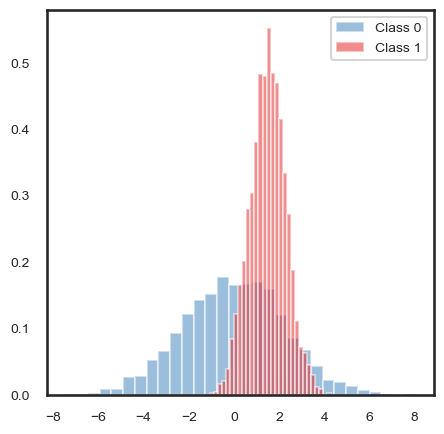

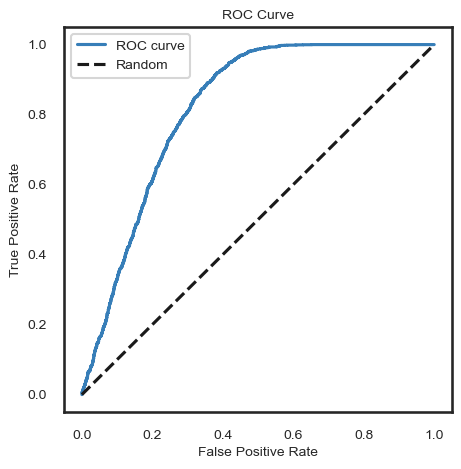

In [280]:
# Generate the data
x_C, y_C, posterior_C, statistics_C, pdf_C = generate_gauss_mix(
    N=N,
    prior=(0.5, 0.5),
    p=1,
    mu_class0=0,
    mu_class1=1.5,
    # mu_class1_0=-1,
    # mu_class1_1=-0,
    sig_class0=5,
    sig_class1=.6,
    # sig_class1_0=.1,
    # sig_class1_1=.1,
    split_class1=None,
)
bins = 30
# print the statistics
print(statistics_C)
# plot the data
fig, ax = plt.subplots( figsize=(5, 5))
# sns.histplot(x_C[y_C.flatten() == 0], binwidth=.1, kde=True, ax=ax)
# sns.histplot(x_C[y_C.flatten() == 1], binwidth=.1,kde=True, ax=ax)
plt.hist(x_C[y_C.flatten() == 0], alpha=0.5, label='Class 0', color=PALETTE[1], density=True, bins=bins)
plt.hist(x_C[y_C.flatten() == 1], alpha=0.5, label='Class 1', color=PALETTE[0], density=True, bins=bins)
ax.tick_params(labelsize=10)
ax.legend(fontsize=10)


# plot the ROC curve
fig, ax = plt.subplots( figsize=(5, 5))
fpr, tpr, thresholds = metrics.roc_curve(y_C, posterior_C, pos_label=1)
ax.plot(fpr, tpr, label="ROC curve")
ax.plot([0, 1], [0, 1], "k--", label="Random")
ax.set_xlabel("False Positive Rate", fontsize=10)
ax.set_ylabel("True Positive Rate", fontsize=10)
ax.set_title("ROC Curve", fontsize=10)
ax.tick_params(labelsize=10)
ax.legend(fontsize=10)


In [80]:

# # plot the true pdfs using seaborn
# fig, ax = plt.subplots(figsize=(6, 5))
# # find the range of the x values
# x_min, x_max = np.min(x), np.max(x)
# xs = np.linspace(x_min-1, x_max+1, 1000)
# # create a df to plot the true pdfs using seaborn
# df = pd.DataFrame(
#     {"x": xs, "pdf_class0": pdf_class0.pdf(xs), "pdf_class1": pdf_class1.pdf(xs)}
# )
# # sample from the true pdfs to plot the histograms
# plt.hist(x_1, bins=100, density=density, alpha=0.6, color=PALETTE[1])
# plt.hist(x_2, bins=100, density=density, alpha=0.3, color=PALETTE[0])
# # find the quantiles of the posterior
# quantile = np.quantile(x_1, [accuracy])
# # plot the quantile
# # plt.axvline(x=quantile, color='g', linestyle='--', label='Threshold')
# # plot the true pdfs
# if density:
#     sns.lineplot(df, x="x", y="pdf_class0", label="Control", color=PALETTE[1])
#     sns.lineplot(df, x="x", y="pdf_class1", label="Cancer", color=PALETTE[0])
# else:
#     plt.plot(
#         df["x"], df["pdf_class0"] * n0 / scaler, color=PALETTE[1], linewidth=2
#     )
#     plt.plot(
#         df["x"], df["pdf_class1"] * n1 / scaler, color=PALETTE[0], linewidth=2
#     )
#     plt.legend(["Control", "Cancer"])

# # set the labels and title
# plt.xlabel("")
# plt.ylabel("Density", size=0.5)
# # set the ticks size
# plt.xticks(size=15)
# plt.yticks(size=15)
# # set the legent size
# sns.set_context("talk", font_scale=1.0)
# plt.title(f"{label}: N({mu_class0[0]},{p0}) vs N({mu_class1[0]},{p1})")

# # plot the ROC curve
# # convert the fpr, tpr, thresholds in a dataframe
# df_roc = pd.DataFrame({"fpr": fpr, "tpr": tpr, "thresholds": thresholds})
# # plot the ROC curve
# plt.figure(figsize=(6, 5))
# plt.plot(df_roc["fpr"], df_roc["tpr"], color=PALETTE[0])
# plt.xlabel("False Positive Rate", size=15.0)
# plt.ylabel("True Positive Rate", size=15.0)
# plt.title(f"ROC Curve: {label}", size=15.0)


,Variable A,Variable B
Accuracy,0.701600,0.624800
MI,0.114134,0.373728
AUC,0.767220,0.620855
S@98,0.166400,0.268800


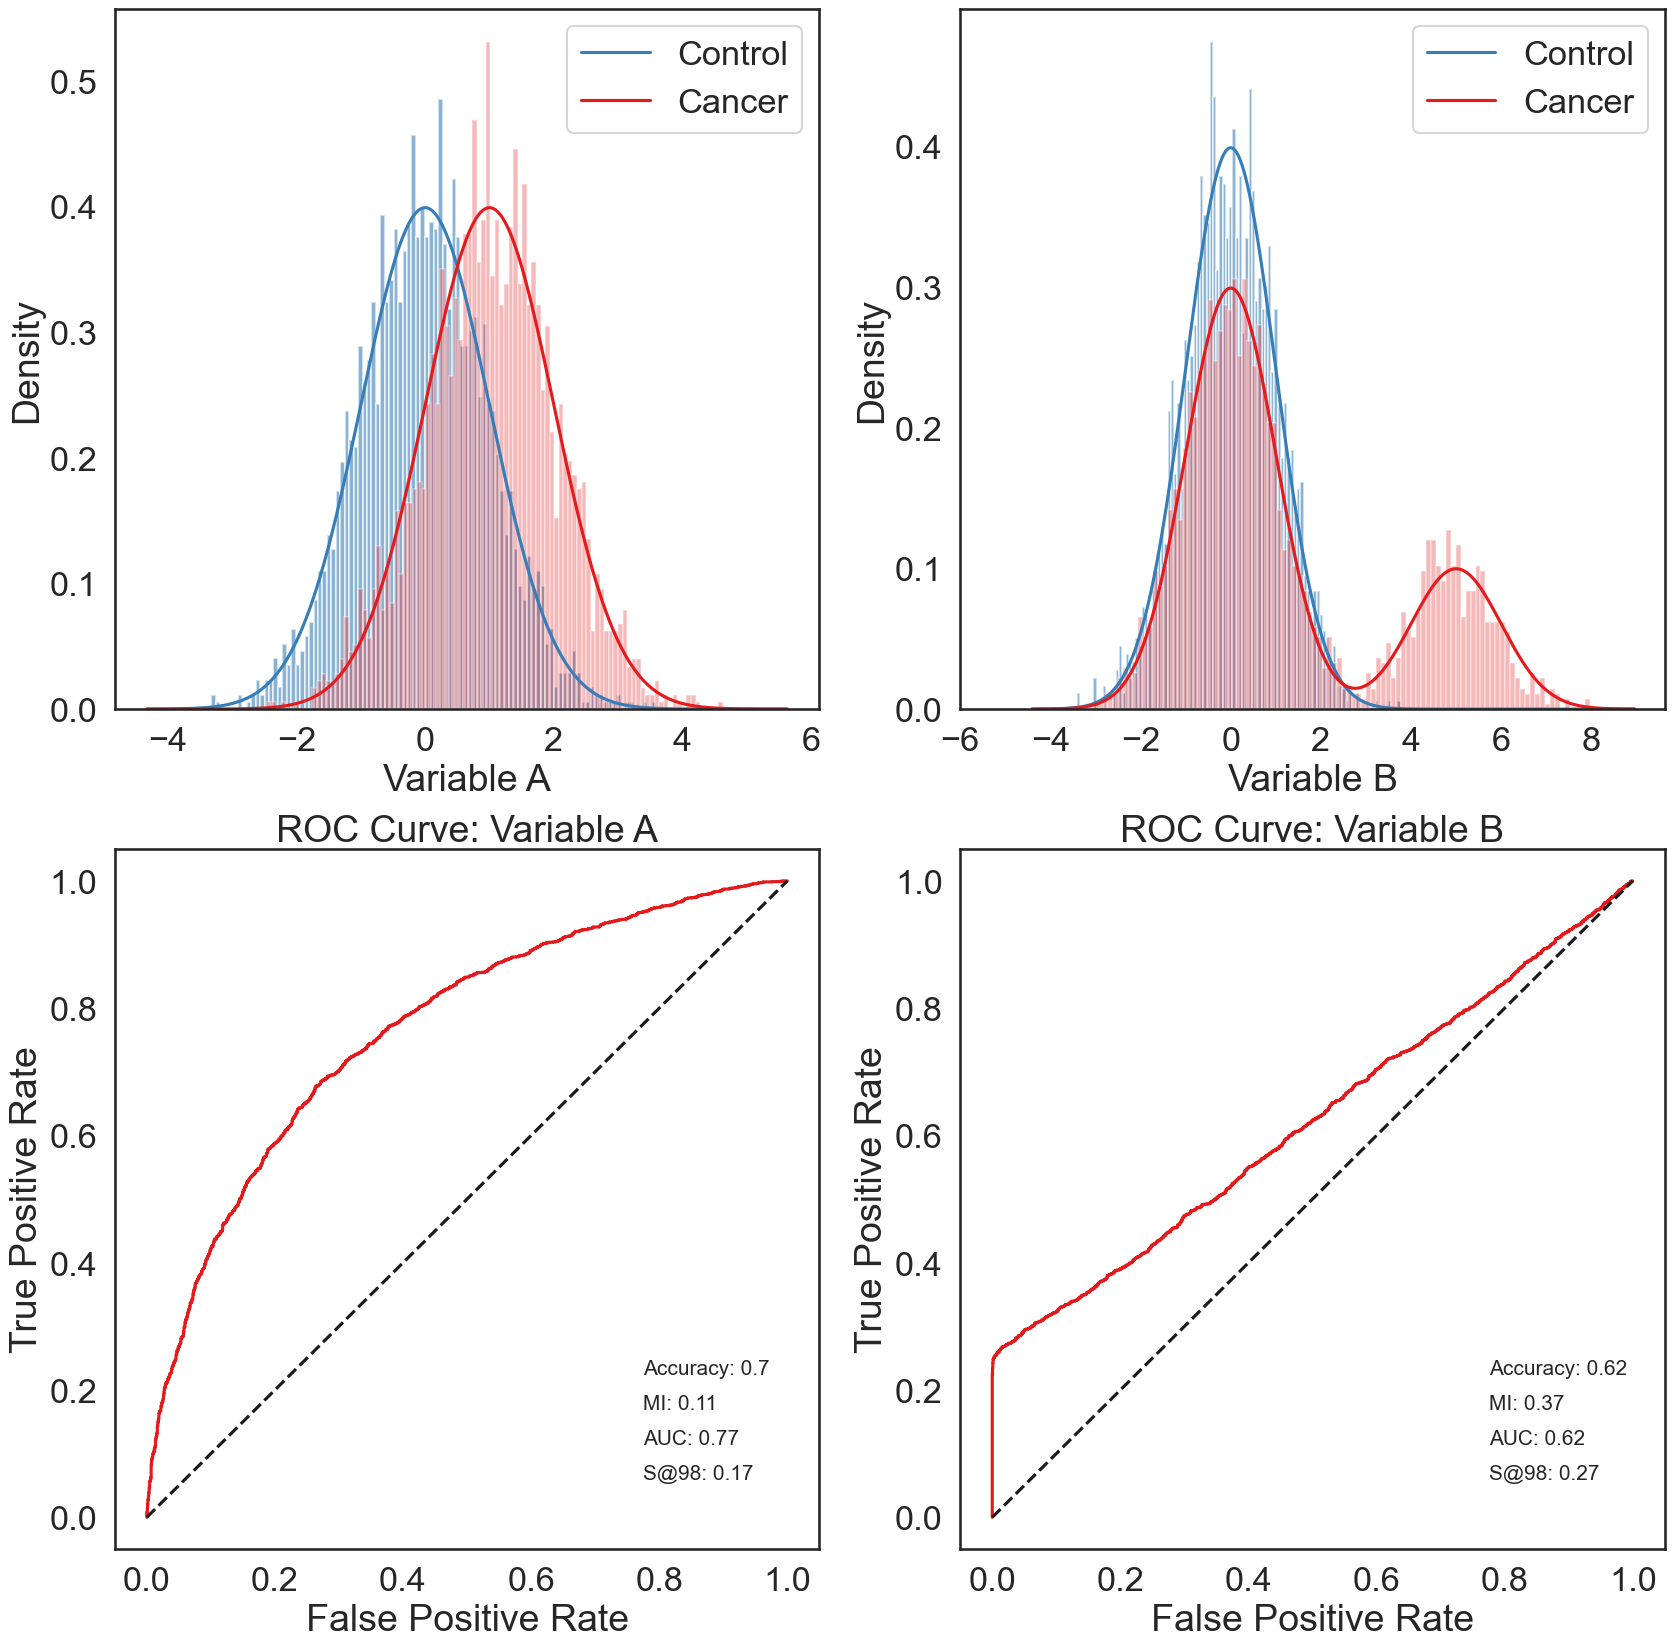

In [143]:
# plot the data
density = True
bins = 100
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
# plot variable A
x_0_A, x_1_A = x_A[y_A == 0], x_A[y_A == 1]
x_0_B, x_1_B = x_B[y_B == 0], x_B[y_B == 1]

# x_min, x_max = np.min(x_A), np.max(x_A)
# xs = np.linspace(x_min-1, x_max+1, 1000)

# sns.histplot(x_0, bins=10, kde=True, ax=ax[0, 0], color=PALETTE[1])
# sns.histplot(x_1, bins=10, kde=True, ax=ax[0, 0], color=PALETTE[0])
ax[0, 0].hist(x_0_A, bins=bins, density=density, alpha=0.6, color=PALETTE[1])
ax[0, 0].hist(x_1_A, bins=bins, density=density, alpha=0.3, color=PALETTE[0])
sns.lineplot(
    pdf_A, x="x", y="pdf_class0", label="Control", color=PALETTE[1], ax=ax[0, 0]
)
sns.lineplot(
    pdf_A, x="x", y="pdf_class1", label="Cancer", color=PALETTE[0], ax=ax[0, 0]
)
# Set the axis labels
ax[0, 0].set_xlabel("Variable A")
ax[0, 0].set_ylabel("Density")
# sns.histplot(x_0, bins=10, kde=True, ax=ax[0, 0], color=PALETTE[1])
# sns.histplot(x_1, bins=10, kde=True, ax=ax[0, 0], color=PALETTE[0])
ax[0, 1].hist(x_0_B, bins=bins, density=density, alpha=0.6, color=PALETTE[1])
ax[0, 1].hist(x_1_B, bins=bins, density=density, alpha=0.3, color=PALETTE[0])
sns.lineplot(
    pdf_B, x="x", y="pdf_class0", label="Control", color=PALETTE[1], ax=ax[0, 1]
)
sns.lineplot(
    pdf_B, x="x", y="pdf_class1", label="Cancer", color=PALETTE[0], ax=ax[0, 1]
)
ax[0, 1].set_xlabel("Variable B")
ax[0, 1].set_ylabel("Density")
# set the xtiks to integers
ax[0, 1].set_xticks(np.arange(-6, 9, 2))

# plot the ROC curve
# convert the fpr, tpr, thresholds in a dataframe
fpr_A, tpr_A, thresholds_A = metrics.roc_curve(
    y_A, posterior_A, pos_label=1, drop_intermediate=False
)
fpr_B, tpr_B, thresholds_B = metrics.roc_curve(
    y_B, posterior_B, pos_label=1, drop_intermediate=False
)
df_roc_A = pd.DataFrame({"fpr": fpr_A, "tpr": tpr_A, "thresholds": thresholds_A})
df_roc_B = pd.DataFrame({"fpr": fpr_B, "tpr": tpr_B, "thresholds": thresholds_B})
# plot the ROC curve
ax[1, 0].plot(df_roc_A["fpr"], df_roc_A["tpr"], color=PALETTE[0])
ax[1, 0].set_xlabel("False Positive Rate")
ax[1, 0].set_ylabel("True Positive Rate")
ax[1, 0].set_title("ROC Curve: Variable A")
ax[1, 0].plot([0, 1], [0, 1], "k--", label="Random")
ax[1, 1].plot(df_roc_B["fpr"], df_roc_B["tpr"], color=PALETTE[0])

ax[1, 1].set_xlabel("False Positive Rate")
ax[1, 1].set_ylabel("True Positive Rate")
ax[1, 1].set_title("ROC Curve: Variable B")
ax[1, 1].plot([0, 1], [0, 1], "k--", label="Random")
# print the statistics
for i, (key, value) in enumerate(statistics_A.items()):
    ax[1, 0].text(
        0.75,
        0.25 - i * 0.05,
        f"{key}: {truncate(value)}",
        fontsize=15,
        transform=ax[1, 0].transAxes,
    )
for i, (key, value) in enumerate(statistics_B.items()):
    ax[1, 1].text(
        0.75,
        0.25 - i * 0.05,
        f"{key}: {truncate(value)}",
        fontsize=15,
        transform=ax[1, 1].transAxes,
    )

statistics_A_list = np.array(list(statistics_A.values()))
statistics_B_list = np.array(list(statistics_B.values()))
df = pd.DataFrame(
    np.vstack((statistics_A_list, statistics_B_list)).T,
    index=statistics_A.keys(),
    columns=["Variable A", "Variable B"],
)
df

In [94]:
print(df.to_latex())

\begin{tabular}{lrr}
\toprule
 & Variable A & Variable B \\
\midrule
Accuracy & 0.701600 & 0.624800 \\
MI & 0.114134 & 0.373728 \\
AUC & 0.767220 & 0.620855 \\
S@98 & 0.166400 & 0.268800 \\
\bottomrule
\end{tabular}

